# EPIC-pn analysis of monitoring results

Using the results of the regular monitoring on calibration lines from Michael Smith scripts.

**Note:** This notebook uses already saved results in pickles from running `monitoring_lines_analysis` notebook!

**Note:** for the boresights CCD#4 only taking the results for `RAWY` in [181:200], which is the last line in the results file.


In [1]:
import os
import glob
import csv
import pickle

%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
#import altair as alt

#from scipy.interpolate import interp1d
#from scipy.interpolate import UnivariateSpline

from datetime import date

In [2]:
today = date.today()
stoday = today.strftime("%d%m%y")

Select the line and the PN mode

In [33]:
#sline = "Al-Ka"
#sline = "Mn-Ka"
sline = "Cu-Ka"
#
# lab energies for the lines, in eV
#
line0 = {'Al-Ka': 1486.0, 'Mn-Ka': 5898.0, 'Cu-Ka': 8040.0}
#
#select_mode = "PrimeFullWindow"
select_mode = "PrimeFullWindowExtended"
xmode = {"PrimeFullWindow": "ff", "PrimeFullWindowExtended": "eff"}

Define the folders and build the list of `OBS_ID`s.

In [34]:
wdir = os.path.expanduser('~') + f'/IVAN/CTI/monitoring/{sline}-line'
if (not os.path.isdir(wdir)):
    print (f"Folder {wdir} does not exist. Cannot continue.")
    raise FileNotFoundError
#

In [35]:
resfile = f'{wdir}/{xmode[select_mode]}_{sline}_fit_results.pickle'
with open(resfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    result = pickle.load(f)

Selected 44/67 good fit results for CCD 1
Selected 64/86 good fit results for CCD 2
Selected 59/84 good fit results for CCD 3
Selected 48/70 good fit results for CCD 4
Selected 60/89 good fit results for CCD 5
Selected 61/87 good fit results for CCD 6
Selected 41/66 good fit results for CCD 7
Selected 50/81 good fit results for CCD 8
Selected 56/82 good fit results for CCD 9
Selected 43/65 good fit results for CCD 10
Selected 52/84 good fit results for CCD 11
Selected 55/83 good fit results for CCD 12


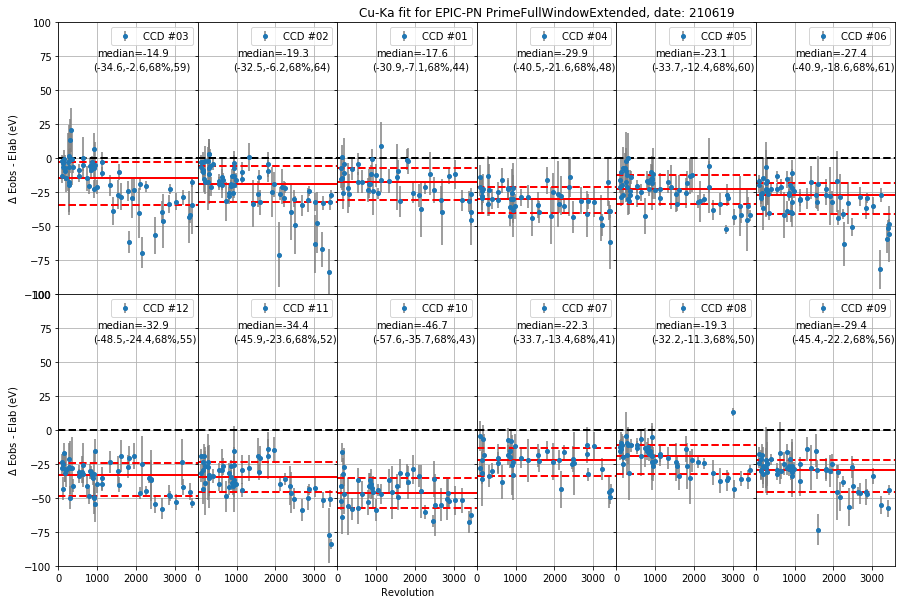

In [36]:

fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
#
chi2r_lim = 1.3
#
mapping = {1: [0,2], 2: [0,1], 3: [0,0], 4: [0,3], 5: [0,4], 6: [0,5],
          7: [1,3], 8: [1,4], 9: [1,5], 10: [1,2], 11: [1,1], 12: [1,0]}
#
runrev = np.arange(0.0,3500.0,200.0)
#
for j in np.arange(12):
    ccd = j + 1
    #
    #
    # filter only those with good fit, i.e. chi2r above chi2r_lim
    #
    #ix = np.where(np.asarray(result[ccd]['chi2r']) <= chi2r_lim)[0]
    # 
    uncert = (np.asarray(result[ccd][f'{sline}_err2']) - np.asarray(result[ccd][f'{sline}_err1']))*5
    ix = np.where((uncert <= 50.0) & (uncert > 0.0))[0]
    print (f"Selected {len(ix)}/{len(result[ccd]['chi2r'])} good fit results for CCD {ccd}")
    #
    xrev = np.asarray(result[ccd]['revol'])[ix]
    xcu = np.asarray(result[ccd][f'{sline}'])[ix]*5.0 # in eV
    xcu_e1 = np.asarray(result[ccd][f'{sline}_err1'])[ix]*5.0 # in eV
    xcu_e2 = np.asarray(result[ccd][f'{sline}_err2'])[ix]*5.0 # in eV
    diff = xcu - line0[sline] # in eV
    diff_err1 = xcu - xcu_e1
    diff_err2 = xcu_e2 - xcu
    diff_err = (diff_err1 + diff_err2)/2.0
    #
    # for the spline we need unique x and strictly increasing
    #qrev, inx = np.unique(xrev, return_index=True)
    #qdif = diff[inx]
    #qdiferr = diff_err[inx]
    #isort = qrev.argsort()
    #
    # smooth curve with univariate weighted spline
    #wxx = 1.0/np.power(qdiferr,2)
    #s = UnivariateSpline(qrev[isort], qdif[isort], w=wxx[isort], k=4,s=2)
    #z = np.polyfit(qrev[isort], qdif[isort], 1)
    #p = np.poly1d(z)
    #qresult = p(runrev)
    #qresult = s(runrev)
    #
    # get the median
    #
    med = np.quantile(diff,0.5)
    mplus = np.quantile(diff,0.84)
    mminus = np.quantile(diff,0.16)
    nq = len(diff)
    axs[mapping[ccd][0],mapping[ccd][1]].errorbar(xrev,diff,yerr=(diff_err1,diff_err2),fmt='o',
                                                  ms=4,ecolor='grey',label=f'CCD #{ccd:02}')
    #axs[mapping[ccd][0],mapping[ccd][1]].plot(runrev,qresult,color='red')
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(med,color='red',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(mplus,color='red',ls='dashed',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(mminus,color='red',ls='dashed',lw=2)
    #axs[kj,k].plot(xrev,diff,'ok',label='')
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(0.0,color='black',ls='dashed',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].text(1000,75,f"median={med:.1f}")
    axs[mapping[ccd][0],mapping[ccd][1]].text(900,65,f"({mminus:.1f},{mplus:.1f},68%,{nq})")
    #
    axs[mapping[ccd][0],mapping[ccd][1]].set_xlim((0,3600))
    axs[mapping[ccd][0],mapping[ccd][1]].set_ylim((-100.0,100.0))
    axs[mapping[ccd][0],mapping[ccd][1]].grid(True)
    axs[mapping[ccd][0],mapping[ccd][1]].legend(loc=1)
    if (ccd == 4):
        axs[mapping[ccd][0],mapping[ccd][1]].set_title(f"{sline} fit for EPIC-PN {select_mode}, date: {stoday}")
    if (ccd == 3 or ccd == 12):
        axs[mapping[ccd][0],mapping[ccd][1]].set_ylabel(r"$\Delta$ Eobs - Elab (eV)")
    if (ccd == 10):
        axs[mapping[ccd][0],mapping[ccd][1]].set_xlabel("Revolution")
#
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/{xmode[select_mode]}_{sline}_monitoring_results_{stoday}.png",dpi=100)
plt.show();
plt.close();